an extension of the ideas behind k-means, can also do prediction. When compared to kmeans the model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty) hence we can use GMM

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\

In [2]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


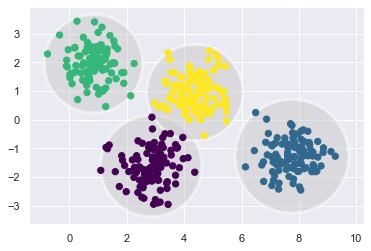

In [4]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

kmeans cannot do anything outside of a circle. GMM allow more elliptical radii of classification

# GMM

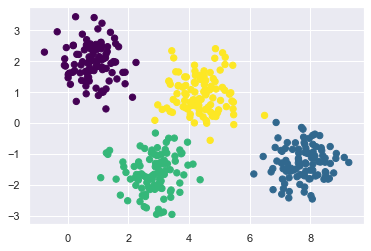

In [11]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

to get probabilist cluster assignment use Scikit-Learn this is done using the predict_proba method. 
This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.    0.    0.531]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


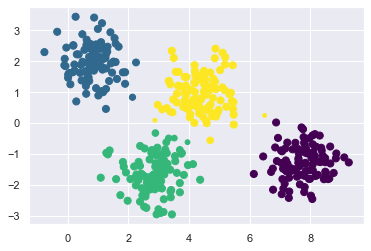

In [9]:
#ok so this is cool, we can make the size of each point based off its certainty. 
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

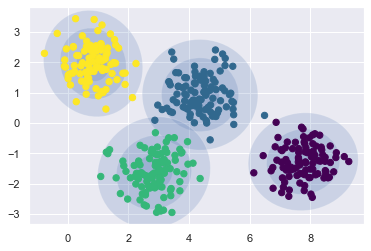

In [14]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

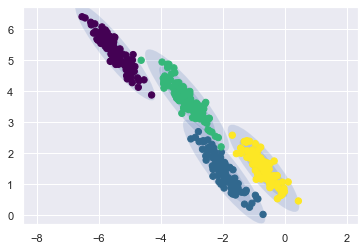

In [17]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))


gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

covariance_type option controls the degrees of freedom in the shape of each cluster. The default is covariance_type="diag", which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes. A slightly simpler and faster model is covariance_type="spherical", which constrains the shape of the cluster such that all dimensions are equal(closer to k-means). covariance_type="full" is computationally more difficult but allows each cluster to be modeled as an ellipse with arbitrary orientation.


Another important aspect is how many components there are 

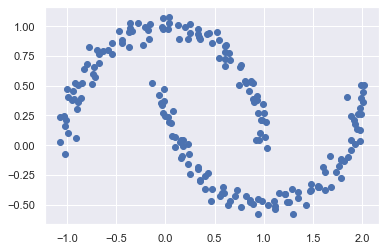

In [18]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

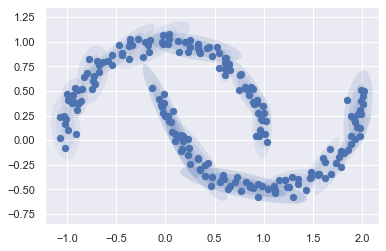

In [19]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

above we see that in fact with more comps we get a model model of the data

# GMM Ellipse

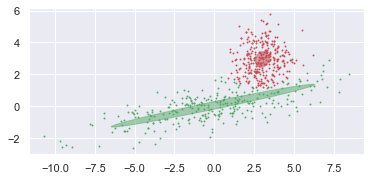

In [75]:
import numpy as np
from sklearn import mixture
import itertools

import pylab as pl
import matplotlib as mpl
from sklearn.mixture import GaussianMixture

n, m = 300, 2

# generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.7], [3.5, .7]])
X = np.r_[np.dot(np.random.randn(n, 2), C),
          np.random.randn(n, 2) + np.array([3, 3])]

gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
splot = pl.subplot(111, aspect='equal')
color_iter = itertools.cycle (['r', 'g', 'b', 'c'])
Y_ = gmm.predict(X)
for i, (mean, covar, color) in enumerate(zip(gmm.means_, gmm.covariances_, color_iter)):
    v, w = np.linalg.eigh(covar)
    u = w[0] / np.linalg.norm(w[0])
    pl.scatter(X[Y_==i, 0], X[Y_==i, 1], .8, color=color)
    angle = np.arctan(u[1]/u[0])
    angle = 180 * angle / np.pi # convert to degrees
    ell = mpl.patches.Ellipse (mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

pl.show()

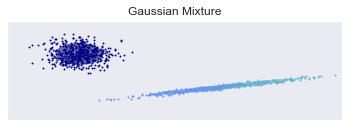

In [59]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')




Automatically created module for IPython interactive environment


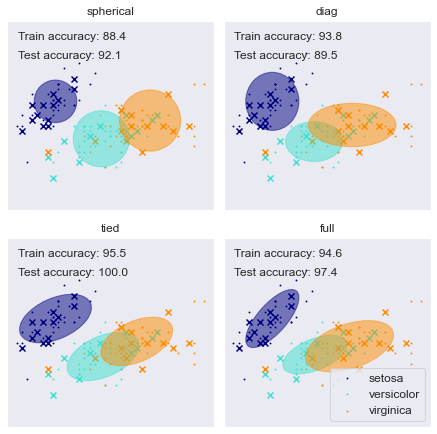

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()